In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [21]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [22]:
def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

In [96]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

In [170]:
def RamseyErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    #delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def RamseyErrSig2(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    #delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, 0.0, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, 0.0, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSig2(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, 0.0, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [77]:
def heatPulse(psi0, t, Omega0, delPrime, eta, nbar0, nbarf, steps, Ncut):
    nbars = np.linspace(nbar0, nbarf, steps)
    print(nbars)
    for ii in range(steps):
        result = psi(0.0+0.0j,0.0+0.0j)
        for n in range(Ncut):
            result += prob(n,nbars[ii])*pulse(t/steps, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
        psi0=result
        print(psi0)
    return psi0

def heatPulse2(psi0, t, Omega0, delPrime, eta, nbar0, nbarf, steps, Ncut):
    nbars = np.linspace(nbar0, nbarf, steps)
    for ii in range(steps):
        psi0 = thermPulse(psi0, t/steps, Omega0, delPrime, eta, nbars[ii], Ncut)
    return psi0

In [132]:
def optimizeDelp(t1, T, delPrime0, eta, nbar0, nbarf, Ncut):
    t2 = 3.0*t1
    Omega0 = np.pi/(2.0*t1)
    psi0 = psi(0.0,1.0)
    x0 = 0.0
    x1 = 0.1
    shift =sp.optimize.root_scalar(HRJumpThermErrSig2, args=(psi0, t1, T, t2, delPrime0, Omega0, eta, 0.0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    dopStark = -nu0*expEHeat(nbar0, nbarf, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
    return delPrime0*(dopStark/shift)

In [168]:
Ncut = 401
nbar0 = 0
nbarf = 0
psi0 = psi(0.0, 1.0)
t1 = 20.0*1e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.0*t1) #hz
T = 500.0e-3
eta = 0.05

pts = 5
delPs = np.linspace(0, 0.1,pts)
deltas = np.zeros(pts)
delta3s = np.zeros(pts)
#delta2s = np.zeros(pts)
#delta4s = np.zeros(pts)
guesstol = 0.1
x0 = -0.1
x1 = 0.1

for ii in range(pts):
    print(delPs[ii])
    delta3s[ii] = sp.optimize.root_scalar(RamseyErrSig2, args=(psi0, t1, T, t2, delPs[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    #deltas[ii] = sp.optimize.root_scalar(HRJumpThermErrSig2, args=(psi0, t1, T, t2, delPs[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    print(delta3s[ii])
    x0 = delta3s[ii] - guessTol
    x1 = delta3s[ii] + guessTol

0.0
0.0
0.025
-0.0006361664855788486
0.05
-0.0012723329526993011
0.07500000000000001
-0.0019084993829023233
0.1
-0.0025446657577296522


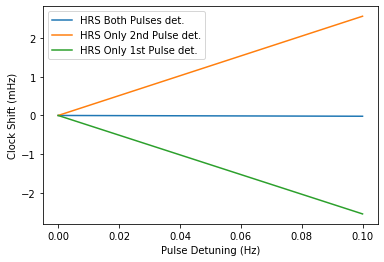

In [169]:
#deltaHRSlastDetune = delta3s
plt.plot(delPs, delta1s*1e3, label="HRS Both Pulses det.")
plt.plot(delPs, delta2s*1e3, label="HRS Only 2nd Pulse det.")
plt.plot(delPs, delta3s*1e3, label="HRS Only 1st Pulse det.")

plt.xlabel("Pulse Detuning (Hz)")
plt.ylabel("Clock Shift (mHz)")
plt.legend()
plt.show()

In [219]:
Ncut = 1
nbar0 = 0
nbarf = 0
psi0 = psi(0.0, 1.0)
t1 = np.pi/2.0
t2 =3.0*t1
Omega0 = 1.0 #hz
T = 1.0
eta = 0.0

pts = 80
delPs = np.linspace(0, 1.5,pts)
deltas = np.zeros(pts)
#delta3s = np.zeros(pts)
#delta2s = np.zeros(pts)
#delta4s = np.zeros(pts)
guesstol = 10.0e-3
x0 = -0.1
x1 = 0.1

for ii in range(pts):
    print(delPs[ii])
    deltas[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, delPs[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    #deltas[ii] = sp.optimize.root_scalar(HRJumpThermErrSig2, args=(psi0, t1, T, t2, delPs[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    print(deltas[ii])
    x0 = deltas[ii] - guessTol
    x1 = deltas[ii] + guessTol

0.0
0.0
0.0189873417721519
-2.148551026727589e-05
0.0379746835443038
-0.00017141496937043694
0.056962025316455694
-0.0005759103721523876
0.0759493670886076
-0.001356557868524474
0.0949367088607595
-0.0026284007722898526
0.11392405063291139
-0.004498221100190207
0.1329113924050633
-0.0070631683359331544
0.1518987341772152
-0.010409768281825514
0.17088607594936708
-0.01461331905367472
0.189873417721519
-0.01973765804950565
0.2088607594936709
-0.02583526494814102
0.22784810126582278
-0.03294765250087499
0.2468354430379747
-0.041105989281335895
0.2658227848101266
-0.05033189619712445
0.2848101265822785
-0.060638360529349795
0.3037974683544304
-0.0720307164142462
0.3227848101265823
-0.08450764784850362
0.34177215189873417
-0.09806217843669973
0.3607594936708861
-0.11268262035589939
0.379746835443038
-0.12835346277126525
0.3987341772151899
-0.14505618680339696
0.4177215189873418
-0.16276999992060917
0.43670886075949367
-0.18147248725332848
0.45569620253164556
-0.20114018085293212
0.474683544

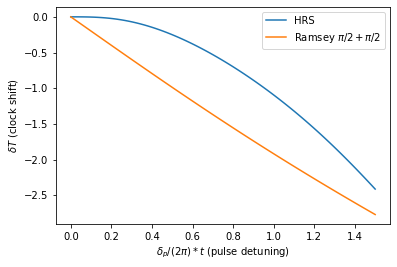

In [220]:
plt.plot(delPs, deltas, label="HRS")
plt.plot(delPs, delta1s, label=r"Ramsey $\pi/2 + \pi/2$")
plt.xlabel(r"$\delta_p/(2\pi)*t$ (pulse detuning)")
plt.ylabel(r"$\delta T $ (clock shift)")
plt.legend()
plt.show()

In [210]:
optimizeDelp(20e-3, 500e-3, 1.0, 0.05, 0.0, 40, 601)

KeyboardInterrupt: 

In [117]:
optimizeDelp(20e-3, 500e-3, 0.5, 0.05, 0.0, 40, 601)

1.529443463363265

In [118]:
optimizeDelp(20e-3, 500e-3, 0.5, 0.05, 0.0, 30, 601)

1.4918399206170079

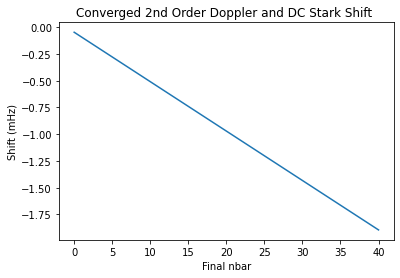

In [97]:
pts = 5
nbarfs = np.linspace(0, 40, pts)
Ncut = 1201
nbar0 = 0.0
shifts = -expEHeat(nbar0, nbarfs, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
plt.plot(nbarfs,shifts*nu0*1.0e3, label="Ncut=1201")
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

In [207]:
Ncut = 1
nbar0 = 0
nbarf = 0
delPrime = 0.12
psi0 = psi(0.0, 1.0)
t1 = np.pi/2.0
t2 = 3.0*t1
Omega0 = 1.0
T = 1.0
eta = 0.0

pts = 50
delds = np.linspace(-0.01, 0.01, pts)
errSigPts = np.zeros(pts)
for ii in range(pts):
    errSigPts[ii] = RamseyErrSig(delds[ii], psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut)

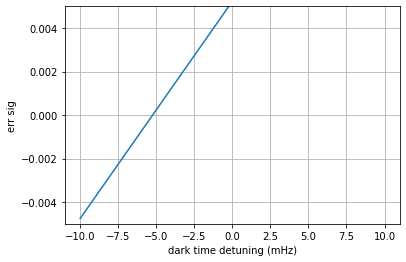

In [208]:
plt.plot(delds*1e3, errSigPts)
plt.xlabel("dark time detuning (mHz)")
plt.ylabel("err sig")
plt.ylim([-0.005, 0.005])
plt.grid()

In [131]:
errSigPts[1]


-0.00012265130223493292

In [134]:
Ncut = 601
pts = 5
nbarfs = np.linspace(0, 40, pts)
psi0 = psi(0.0, 1.0)
delPrime = 0.07833 #0.270*2.0*np.pi #hz
t1 = 20.0e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.0*t1) #hz
T = 500.0e-3
eta = 0.05
shifts1 = np.zeros(pts)
shifts2 = np.zeros(pts)
nbarfStars = nbarfs*(t1+T)/(t1+t2+T)
nbar0s = nbarfs*t1/(t1+t2+T)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts1[ii] = sp.optimize.root_scalar(HRJumpThermErrSig2, args=(psi0, t1, T, t2, delPrime, Omega0, eta, 0.0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0.0
0.001993228781863562
10.0
0.0019662294190616095
20.0
0.0019414614161726142
30.0
0.0019183924890165546
40.0
0.0018965941050121126


In [93]:
x0 = -0.1
x1 = 0.5
for ii in range(pts):
    print(nbarfs[ii])
    shifts2[ii] = sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, delPrime, Omega0, eta, nbar0s[ii], nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts2[ii])
    x0 = shifts2[ii] - guessTol
    x1 = shifts2[ii] + guessTol
    #print(x0,x1)

0.0
-2.5208598905860598e-08
10.0
-3.823447851707956e-05
20.0
-7.317276495582165e-05
30.0
-0.00010562152463708326
40.0
-0.00013620988873290816


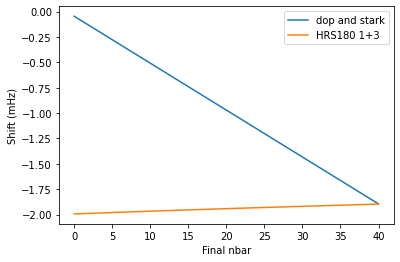

In [136]:
plt.plot(nbarfs, shifts*nu0*1.0e3, label="dop and stark")
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.plot(nbarfs, -shifts1*1e3, label="HRS180 1+3")
plt.legend()
#plt.plot(nbarfs, shifts2*1e3)

Text(0.5, 0, 'final nbar')

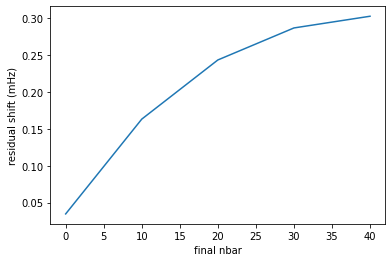

In [112]:
plt.plot(nbarfs, (shifts*nu0-shifts1)*1e3)
plt.ylabel("residual shift (mHz)")
plt.xlabel("final nbar")

In [88]:
psi0 = psi(1.0, 0.0)
t = 30*1e-3
Omega0 = np.pi/(2.0*t)
delPrime = 0.1
eta = 0.05
nbar0 = 1.0
nbarf = 1.0
steps = 8
Ncut = 600
#psi3 = heatPulse(psi0, t, Omega0, delPrime, eta, nbar0, nbarf, steps, Ncut)
psi1 = heatPulse2(psi0, t, Omega0, delPrime, eta, nbar0, nbarf, steps, Ncut)
psi2 = thermPulse(psi0, t, Omega0, delPrime, eta, nbar0, Ncut)
#psi1 = pulse(t, Omega0, delPrime, 0.0, 0.0)@psi0
psi1

array([ 0.7091823 -2.87783617e-04j, -0.00105754+7.05023621e-01j])

In [89]:
psi2

array([ 0.70917992-2.87786203e-04j, -0.00105753+7.05021266e-01j])

In [74]:
psi3

array([ 0.70918128-2.87784022e-04j, -0.00105753+7.05022611e-01j])

In [26]:
psi1

array([[ 9.99999742e-01-3.08281631e-04j, -5.37112563e-04+3.65302141e-04j],
       [-5.37112563e-04+3.65302141e-04j, -3.67746168e-01+9.29925983e-01j]])

In [51]:
prob(1,10)

0.08264462809917356

In [48]:
t

0.02

In [64]:
range(1)

range(0, 1)

In [65]:
for ii in range(1):
    print(ii)

0


In [102]:
shifts[4]*nu0/shifts1[4]

14.706816768557362

In [101]:
shifts1[4]

-0.00012885325651177727

In [104]:
18.303*14.706816768557362*1e-3

0.2691788673149054